<a href="https://colab.research.google.com/github/jespimentel/perfil_procuradoria_mpsp/blob/master/antiguidade_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
arquivos = ['/content/drive/MyDrive/Datasets/listas_ant/Lista-I-Procurador.pdf','/content/drive/MyDrive/Datasets/listas_ant/Lista-II-Final.pdf',
          '/content/drive/MyDrive/Datasets/listas_ant/Lista-III-Intermediaria.pdf','/content/drive/MyDrive/Datasets/listas_ant/Lista-IV-Inicial.pdf',
          '/content/drive/MyDrive/Datasets/listas_ant/Lista-V-Substituto.pdf'] # Total: 1944 membros

In [2]:
!pip install pymupdf

In [3]:
import fitz
import re
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Funções

def extrai_texto(arquivo):
  """Extrai o texto do PDF"""
  texto = ''
  with fitz.open(arquivo) as pdf:
    for pagina in pdf:
      texto += pagina.get_text() # type(texto) = str
  return texto

def encontra_membros(texto):
  """Encontra os membros por RegEx"""
  r = re.compile('[0-9]+\n[0-9]+\n[A-ZÀ-Ú].+') # Admite acentos
  resultado = r.findall(texto)
  return resultado

def gera_lista (resultado, texto):
  """Gera a lista de membros"""
  for r in resultado:
    texto = texto.replace(r, '|' + r) # Marca as correspondências com o padrão
  texto = texto.replace('\n', ',')
  texto = texto.split('|') # Converte em lista (uma linha por membro)
  texto = texto[1:] # Suprime o cabeçalho
  lista_membros=list() # Gera a lista de listas
  for n in texto:
    n = n.split(',')
    n = n[:17]
    lista_membros.append(n)
  return lista_membros

def limpa_lista(lista_membros):
  """Limpa a lista"""
  nova_lista_membros=[]
  for membro in lista_membros:
    r = re.compile('\d{2}/\d{2}/\d{4}')
    datas=[]
    for n in membro:
      if r.search(n):
        datas.append(r.findall(n)[0])
    nova_lista_membros.append(membro[0:5] + datas)
  print(f'Foram encontrados {len(nova_lista_membros)} membros na lista em processamento.')
  return (nova_lista_membros)

def inclui_fonte(lista, arquivo):
  """Inclui o nome do arquivo de origem nas listas geradas"""
  nome_arquivo = arquivo.split('/')[-1]
  for membro in lista:
    membro.insert(5, nome_arquivo)
    print(membro)
  return lista

def define_situacao_atual(lista):
  """Gera a lista com as datas relevantes para a classificação"""
  nova_lista=[]
  for exemplo in lista:
    novo_exemplo = exemplo[0:3]+ exemplo[4:6]
    if exemplo[3]=='22/12/2005':
      novo_exemplo.append(exemplo[-5]) # Data de promoção considerada para a posição da lista
      novo_exemplo.append(exemplo[-3])
      novo_exemplo.append(exemplo[-1])
    else:
      novo_exemplo.append(exemplo[-4]) # Data da inclusão na lista se diferente de 22/12/2005
      novo_exemplo.append(exemplo[-3])
      novo_exemplo.append(exemplo[-1])
    nova_lista.append(novo_exemplo)
  return nova_lista

In [5]:
lista_geral=[]
for arquivo in arquivos:
  nome_arquivo = arquivo.split('/')[-1]
  texto = extrai_texto(arquivo)
  resultado = encontra_membros(texto)
  lista = gera_lista(resultado, texto)
  lista = limpa_lista(lista)
  for l in lista:
    l.insert(5, nome_arquivo) # Inclui a origem dos dados
  lista_geral.extend(lista)
lista_todos_membros = define_situacao_atual(lista_geral)
print(f'Total: {len(lista_todos_membros)}')

Foram encontrados 300 membros na lista em processamento.
Foram encontrados 1091 membros na lista em processamento.
Foram encontrados 254 membros na lista em processamento.
Foram encontrados 201 membros na lista em processamento.
Foram encontrados 98 membros na lista em processamento.
Total: 1944


In [6]:
print(f'Lista 1 (Procuradores): {round(300/1994*100,2)}.%')
print(f'Lista 2 (Finais): {round(1091/1994*100,2)}.%')
print(f'Lista 3 (Intermediárias): {round(254/1994*100,2)}.%')
print(f'Lista 4 (Iniciais): {round(201/1994*100,2)}.%')
print(f'Lista 5 (Substitutos): {round(98/1994*100,2)}.%')

Lista 1 (Procuradores): 15.05.%
Lista 2 (Finais): 54.71.%
Lista 3 (Intermediárias): 12.74.%
Lista 4 (Iniciais): 10.08.%
Lista 5 (Substitutos): 4.91.%


In [7]:
colunas = ['Classif.', 'Matr.', 'Nome', 'Cargo', 'Origem', 'Data-lista', 'Carreira', 'Nascimento']
df = pd.DataFrame(lista_todos_membros, columns=colunas)
df['Data-lista'] = pd.to_datetime(df['Data-lista'], infer_datetime_format=True)
df['Carreira'] = pd.to_datetime(df['Carreira'], infer_datetime_format=True)
df['Nascimento'] = pd.to_datetime(df['Nascimento'], infer_datetime_format=True)
df['Idade atual'] = (datetime.now()- df['Nascimento'])/ np.timedelta64(1, 'Y')
df['Tempo após data-lista'] = (datetime.now()- df['Data-lista'])/ np.timedelta64(1, 'Y')
df['Idade promocao'] = (df['Data-lista'] - df['Nascimento'])/np.timedelta64(1, 'Y')
df['Tempo carr. prom.'] = (df['Data-lista'] - df['Carreira'])/np.timedelta64(1, 'Y')
df['Tempo carr. total'] = (datetime.now()- df['Carreira'])/ np.timedelta64(1, 'Y')
df['Idade ingresso'] = (df['Carreira'] - df['Nascimento'])/np.timedelta64(1, 'Y')
df = df[['Classif.', 'Matr.', 'Nome', 'Cargo', 'Origem', 'Data-lista','Idade promocao', 'Tempo carr. prom.',
         'Tempo após data-lista', 'Carreira', 'Tempo carr. total','Idade ingresso','Nascimento', 'Idade atual']]
df[['Classif.', 'Matr.', 'Origem', 'Data-lista','Idade promocao', 'Tempo carr. prom.','Tempo após data-lista',
    'Carreira', 'Tempo carr. total','Idade ingresso','Nascimento', 'Idade atual']]

,Classif.,Matr.,Origem,Data-lista,Idade promocao,Tempo carr. prom.,Tempo após data-lista,Carreira,Tempo carr. total,Idade ingresso,Nascimento,Idade atual
0,1,618461,Lista-I-Procurador.pdf,1985-12-28,31.565330,8.290382,36.113005,1977-09-13,44.403388,23.274947,1954-06-05,67.678335
1,2,480141,Lista-I-Procurador.pdf,1988-06-29,35.918602,12.460215,33.610558,1976-01-13,46.070773,23.458387,1952-07-29,69.529160
2,3,152307,Lista-I-Procurador.pdf,1988-09-29,36.671526,9.829086,33.358671,1978-12-01,43.187757,26.842440,1952-01-28,70.030197
3,4,534178,Lista-I-Procurador.pdf,1989-11-07,39.239683,13.125526,32.252556,1976-09-22,45.378083,26.114157,1950-08-12,71.492240
4,5,444963,Lista-I-Procurador.pdf,1992-01-11,38.442952,14.327467,30.075920,1977-09-13,44.403388,24.115485,1953-08-02,68.518873
...,...,...,...,...,...,...,...,...,...,...,...,...
1939,94,011376,Lista-V-Substituto.pdf,2021-01-07,32.791912,0.000000,1.084223,2021-01-07,1.084223,32.791912,1988-03-24,33.876135
1940,95,011378,Lista-V-Substituto.pdf,2021-01-07,31.819955,0.000000,1.084223,2021-01-07,1.084223,31.819955,1989-03-14,32.904178
1941,96,011379,Lista-V-Substituto.pdf,2021-01-07,28.526253,0.000000,1.084223,2021-01-07,1.084223,28.526253,1992-06-29,29.610476
1942,97,011380,Lista-V-Substituto.pdf,2021-01-07,31.094410,0.000000,1.084223,2021-01-07,1.084223,31.094410,1989-12-04,32.178633


In [8]:
hoje = datetime.today().strftime('%Y-%m-%d')
df.to_excel(f'listas_{hoje}.xlsx')

In [9]:
procuradores = df[df['Origem']=='Lista-I-Procurador.pdf']
final = df[df['Origem']=='Lista-II-Final.pdf']
intermediaria = df[df['Origem']=='Lista-III-Intermediaria.pdf']
inicial = df[df['Origem']=='Lista-IV-Inicial.pdf']
substitutos = df[df['Origem']=='Lista-V-Substituto.pdf']

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning



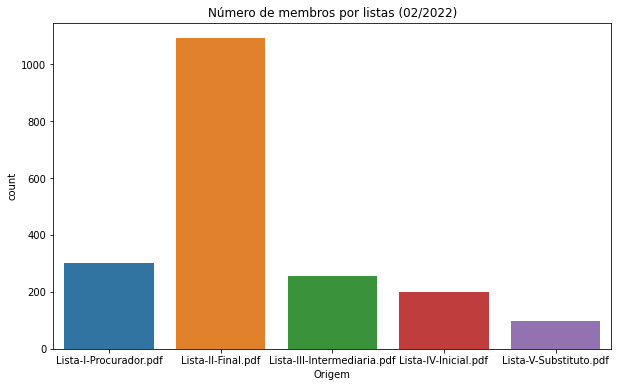

In [10]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(df['Origem'])
ax.set_title('Número de membros por listas (02/2022)')
plt.savefig('01_n_membros_listas.jpg')
plt.show()

In [11]:
(df.groupby(['Origem'])['Nome'].count())

Origem
Lista-I-Procurador.pdf          300
Lista-II-Final.pdf             1091
Lista-III-Intermediaria.pdf     254
Lista-IV-Inicial.pdf            201
Lista-V-Substituto.pdf           98
Name: Nome, dtype: int64

In [12]:
df['Idade atual'].describe()

count    1944.000000
mean       49.243138
std         9.670910
min        27.603590
25%        41.546382
50%        49.416495
75%        56.201029
max        74.955692
Name: Idade atual, dtype: float64

In [13]:
df['Tempo carr. total'].describe()

count    1944.000000
mean       21.421916
std        10.819204
min         1.084223
25%        10.858551
50%        22.650717
75%        30.136154
max        49.071519
Name: Tempo carr. total, dtype: float64

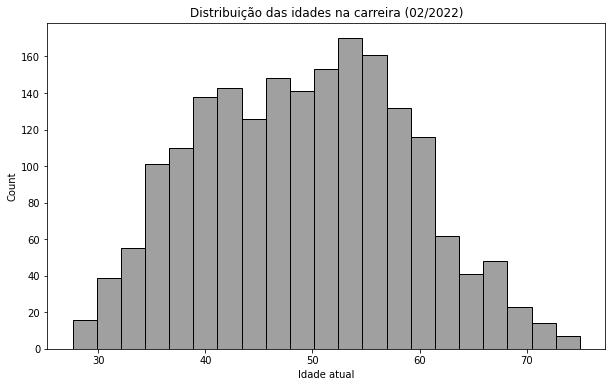

In [14]:
plt.figure(figsize=(10, 6))
ax = sns.histplot(df['Idade atual'], color='gray')
ax.set_title('Distribuição das idades na carreira (02/2022)')
plt.savefig('02_idades_careira.jpg')
plt.show()

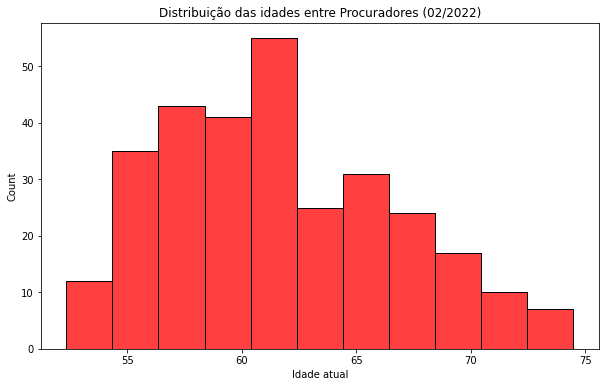

In [15]:
plt.figure(figsize=(10, 6))
ax = sns.histplot(procuradores['Idade atual'], color='r')
ax.set_title('Distribuição das idades entre Procuradores (02/2022)')
plt.savefig('03_idades_procuradores.jpg')
plt.show()

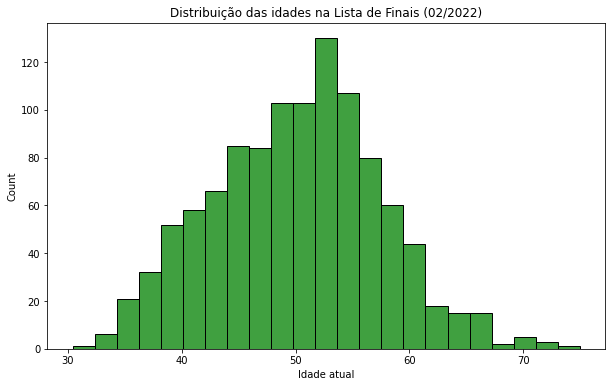

In [16]:
plt.figure(figsize=(10, 6))
ax = sns.histplot(final['Idade atual'], color='g')
ax.set_title('Distribuição das idades na Lista de Finais (02/2022)')
plt.savefig('04_idades_finais.jpg')
plt.show()

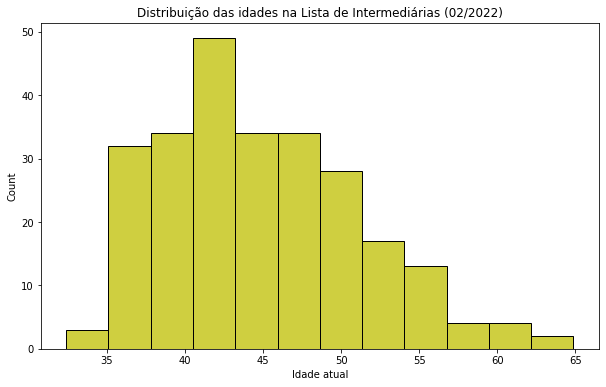

In [17]:
plt.figure(figsize=(10, 6))
ax = sns.histplot(intermediaria['Idade atual'], color='y')
ax.set_title('Distribuição das idades na Lista de Intermediárias (02/2022)')
plt.savefig('05_idades_intermediarias.jpg')
plt.show()

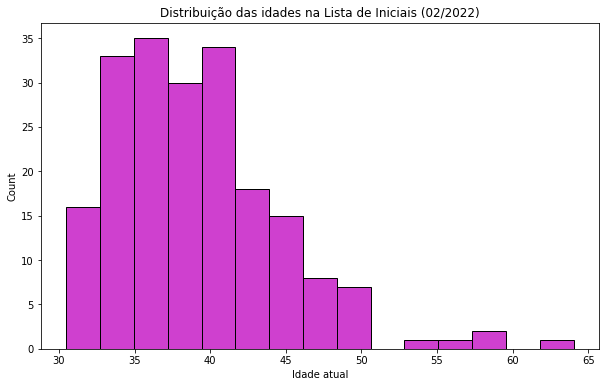

In [18]:
plt.figure(figsize=(10, 6))
ax = sns.histplot(inicial['Idade atual'], color='m')
ax.set_title('Distribuição das idades na Lista de Iniciais (02/2022)')
plt.savefig('06_idades_iniciais.jpg')
plt.show()

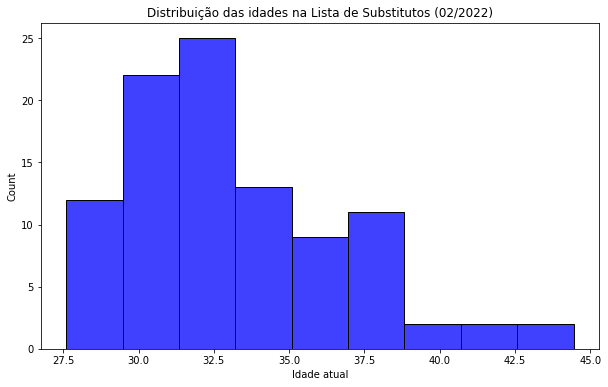

In [19]:
plt.figure(figsize=(10, 6))
ax = sns.histplot(substitutos['Idade atual'], color='b')
ax.set_title('Distribuição das idades na Lista de Substitutos (02/2022)')
plt.savefig('07_idade_substitutos.jpg')
plt.show()

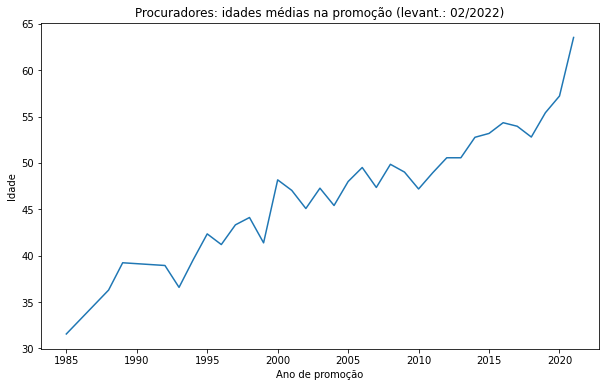

In [20]:
plt.figure(figsize=(10, 6))
dados=procuradores.groupby(procuradores['Data-lista'].dt.year)['Idade promocao'].mean()
dados.plot(xlabel='Ano de promoção', ylabel='Idade').set_title('Procuradores: idades médias na promoção (levant.: 02/2022)')
plt.savefig('08_idades_promocao_procuradores.jpg')
plt.show()

In [21]:
dados.tail(12)

Data-lista
2010    47.191478
2011    48.935394
2012    50.555453
2013    50.554768
2014    52.761293
2015    53.178368
2016    54.333080
2017    53.951932
2018    52.790133
2019    55.410653
2020    57.211094
2021    63.519990
Name: Idade promocao, dtype: float64

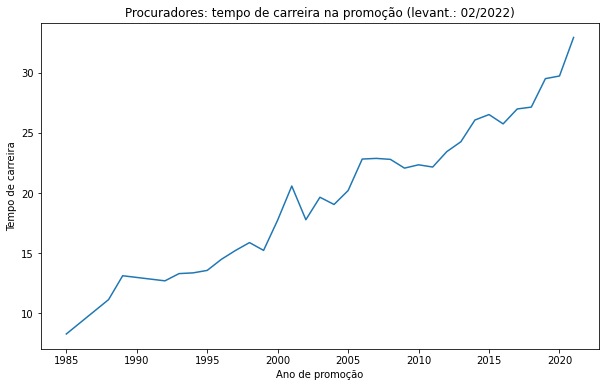

In [22]:
plt.figure(figsize=(10, 6))
dados1=procuradores.groupby(procuradores['Data-lista'].dt.year)['Tempo carr. prom.'].mean()
dados1.plot(xlabel='Ano de promoção', ylabel='Tempo de carreira').set_title('Procuradores: tempo de carreira na promoção (levant.: 02/2022)')
plt.savefig('09_tempo_carreira_promocao_procuradores.jpg')
plt.show()

In [23]:
dados1.tail(12)

Data-lista
2010    22.337671
2011    22.151754
2012    23.429515
2013    24.251468
2014    26.058030
2015    26.509556
2016    25.735641
2017    26.974070
2018    27.128825
2019    29.492289
2020    29.712188
2021    32.911285
Name: Tempo carr. prom., dtype: float64

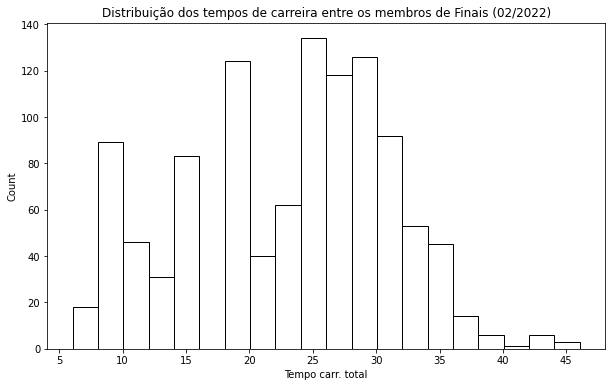

In [24]:
plt.figure(figsize=(10, 6))
ax = sns.histplot(final['Tempo carr. total'], color='white')
ax.set_title('Distribuição dos tempos de carreira entre os membros de Finais (02/2022)')
plt.savefig('10_tempo_carreira_final.jpg')
plt.show()

In [25]:
procuradores['Tempo carr. total'].describe()

count    300.000000
mean      34.856096
std        3.785768
min       28.249736
25%       32.236129
50%       34.084216
75%       36.750938
max       49.071519
Name: Tempo carr. total, dtype: float64

In [26]:
procuradores['Idade atual'].describe()

count    300.000000
mean      61.681570
std        5.012331
min       52.335104
25%       57.999834
50%       60.937608
75%       65.399028
max       74.484772
Name: Idade atual, dtype: float64

In [27]:
final['Tempo carr. total'].describe()

count    1091.000000
mean       23.016033
std         8.143058
min         6.045311
25%        18.406961
50%        25.153164
75%        29.131342
max        46.070773
Name: Tempo carr. total, dtype: float64

In [28]:
final['Idade atual'].describe()

count    1091.000000
mean       50.131440
std         7.369757
min        30.431848
25%        44.842822
50%        50.659505
75%        55.161993
max        74.955692
Name: Idade atual, dtype: float64

In [29]:
df_2021 = df[df['Data-lista']>='2021-01-01']
df_2021.groupby('Origem')['Idade promocao'].describe()


,count,mean,std,min,25%,50%,75%,max
Origem,,,,,,,,
Lista-I-Procurador.pdf,5.0,63.519990,5.049839,60.288712,60.639164,60.652854,63.842516,72.176705
Lista-II-Final.pdf,42.0,41.354586,6.193534,33.046538,36.134212,39.885829,44.944797,57.764362
Lista-III-Intermediaria.pdf,44.0,39.339057,4.224335,32.559190,36.227301,38.711267,41.312279,54.689692
Lista-IV-Inicial.pdf,45.0,34.988687,3.645197,29.473569,32.679658,34.316926,38.078811,43.562838
Lista-V-Substituto.pdf,76.0,31.471773,3.197753,26.519367,29.302450,30.839785,33.418893,41.947473


In [30]:
df_2021 = df[df['Data-lista']>='2021-01-01']
df_2021.groupby('Origem')['Tempo carr. prom.'].describe()

,count,mean,std,min,25%,50%,75%,max
Origem,,,,,,,,
Lista-I-Procurador.pdf,5.0,32.911285,2.567016,29.090262,31.967802,33.164268,34.607145,35.726949
Lista-II-Final.pdf,42.0,12.352263,6.974475,5.273209,5.692109,10.212393,17.886746,30.084122
Lista-III-Intermediaria.pdf,44.0,9.728530,4.104798,5.273209,7.288308,7.978261,11.945488,19.310458
Lista-IV-Inicial.pdf,45.0,4.320661,1.901381,2.636604,2.636604,2.880278,5.273209,7.608644
Lista-V-Substituto.pdf,76.0,0.000973,0.008480,0.000000,0.000000,0.000000,0.000000,0.073923
